# 12-752 Final Project
#### Authors: Ben Neiman (bneiman), Parangat Shukla (parangas)

## Step 1: Importing and Cleaning Data

Import libraries:

In [1]:
import sklearn
sklearn.__version__

'0.18.1'

In [2]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split

%matplotlib inline

Importing the data and the column names from the codebook:

In [5]:
column_names = pd.read_excel('Dataset/langevincodebook.xlsx',sheetname = 'Sheet2')
data_names = column_names['Description'].values

data = pd.read_csv('Dataset/LANGEVIN_DATA.txt',sep=' ',names = data_names,index_col =False)

The time in the data is measured with MATLAB's absolute time, converting to a meaningful timestamp:

In [6]:
def toTimestamp(datenum):
    python_datetime = dt.datetime.fromordinal(int(datenum) - 366) + dt.timedelta(days=datenum%1)
    return python_datetime

In [7]:
data['Timestamp'] = [toTimestamp(data['Time'][date]) for date in range(len(data['Time']))]
data['Occupant Number']=data['Occupant Number'].astype(int)
data['Hour'] = data['Timestamp'].dt.hour
data['Month'] = data['Timestamp'].dt.month

Now we need to remove any times where there is no Thermal comfort measurement taken and select our uncontrollable variables:

In [8]:
data = data[pd.notnull(data['General Thermal Comfort (right now)'])]
uncont_data = data[['Occupant Number','Timestamp','Gender','Age','General Thermal Comfort (right now)','INDOOR Ambient Temp.','INDOOR Relative Humidity','OUTDOOR Ambient Temp.','OUTDOOR Relative Humidity','INDOOR Air Velocity','OUTDOOR Air Velocity','Hour','Month']]


Check if there are still any null values left and check where they are:

Occupant Number                         0
Timestamp                               0
Gender                                  0
Age                                    89
General Thermal Comfort (right now)     0
INDOOR Ambient Temp.                   17
INDOOR Relative Humidity                0
OUTDOOR Ambient Temp.                   0
OUTDOOR Relative Humidity               0
INDOOR Air Velocity                     0
OUTDOOR Air Velocity                    0
Hour                                    0
Month                                   0
dtype: int64


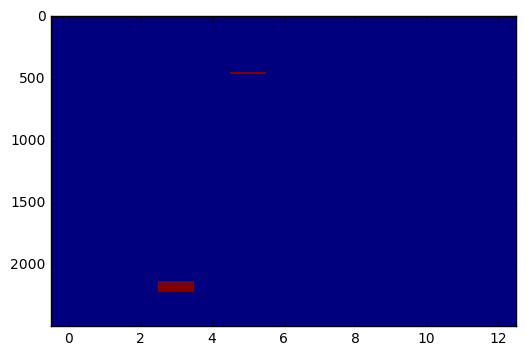

In [9]:
print(uncont_data.isnull().sum())
o = uncont_data.isnull().values
plt.imshow(o,aspect = 'auto',interpolation = 'nearest')

#### Comments:
- Occupant 21 has no age data.
- Missing 17 indoor temp values for occupant 5.

Now to remove those rows with nulls:

In [10]:
uncont_data = uncont_data.dropna()

In [11]:
uncont_data.head(10)

,Occupant Number,Timestamp,Gender,Age,General Thermal Comfort (right now),INDOOR Ambient Temp.,INDOOR Relative Humidity,OUTDOOR Ambient Temp.,OUTDOOR Relative Humidity,INDOOR Air Velocity,OUTDOOR Air Velocity,Hour,Month
708,1,2012-08-06 09:00:00.000000,2.0,32.0,4.0,23.721585,61.785,28.0,66.0,0.030988,4.47040,9,8
720,1,2012-08-06 12:00:00.000000,2.0,32.0,3.0,23.980518,58.670,30.0,46.0,0.030988,4.02336,12,8
736,1,2012-08-06 16:00:00.028804,2.0,32.0,5.0,24.066829,54.120,32.0,38.0,0.030988,5.81152,16,8
810,1,2012-08-07 10:30:00.000000,2.0,32.0,4.0,23.290030,49.107,27.0,51.0,0.030988,1.34112,10,8
817,1,2012-08-07 12:15:00.028804,2.0,32.0,5.0,23.548963,48.594,28.0,48.0,0.030988,1.34112,12,8
832,1,2012-08-07 16:00:00.028804,2.0,32.0,5.0,23.807896,48.598,29.0,51.0,0.030988,2.23520,16,8
900,1,2012-08-08 09:00:00.000000,2.0,32.0,5.0,23.548963,57.738,27.0,79.0,0.030988,2.68224,9,8
912,1,2012-08-08 12:00:00.000000,2.0,32.0,5.0,23.980518,55.620,31.0,43.0,0.030988,2.68224,12,8
928,1,2012-08-08 16:00:00.028804,2.0,32.0,4.0,24.066829,53.037,30.0,46.0,0.030988,2.68224,16,8
996,1,2012-08-09 09:00:00.000000,2.0,32.0,3.0,23.376341,59.721,28.0,70.0,0.030988,1.34112,9,8


With the data cleaned we move on to the analysis.

## Step 2: Exploratory Analysis

We thought it would be interesting to look at how much the indoor/outdoor measurements vary from each other to get an idea for how climate controlled the building is.

In [24]:
uncont_data[['INDOOR Ambient Temp.','OUTDOOR Ambient Temp.']].corr().iloc[0,1]

0.52134136896107652

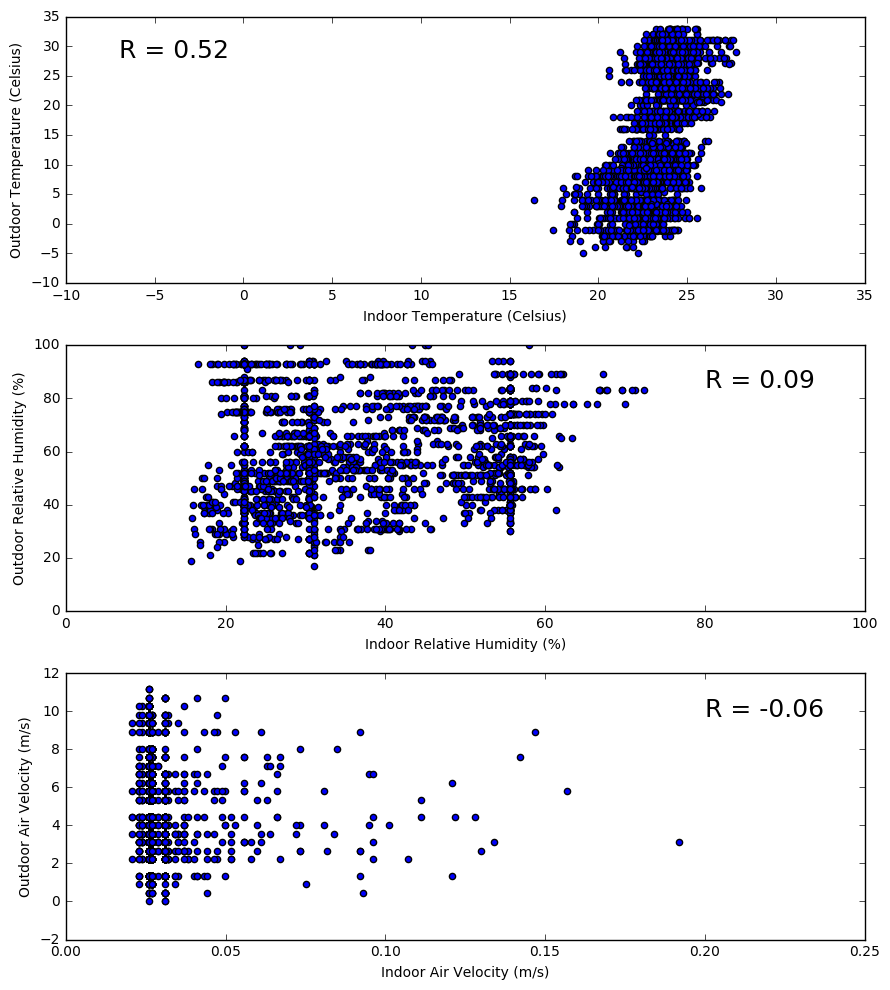

In [70]:
fig = plt.figure(figsize=(9,10))
plt.subplot(311)
plt.scatter(uncont_data['INDOOR Ambient Temp.'],uncont_data['OUTDOOR Ambient Temp.'])
plt.annotate('R = %0.2f'%uncont_data[['INDOOR Ambient Temp.','OUTDOOR Ambient Temp.']].corr().iloc[0,1],xy=(-7,28),fontsize=18.0)
plt.xlim(-10,35)
plt.xlabel('Indoor Temperature (Celsius)')
plt.ylabel('Outdoor Temperature (Celsius)')


plt.subplot(312)
plt.scatter(uncont_data['INDOOR Relative Humidity'],uncont_data['OUTDOOR Relative Humidity'])
plt.annotate('R = %0.2f'%uncont_data[['INDOOR Relative Humidity','OUTDOOR Relative Humidity']].corr().iloc[0,1],xy=(80,84),fontsize = 18.0)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('Indoor Relative Humidity (%)')
plt.ylabel('Outdoor Relative Humidity (%)')


plt.subplot(313)
plt.scatter(uncont_data['INDOOR Air Velocity'],uncont_data['OUTDOOR Air Velocity'])
plt.annotate('R = %0.2f'%uncont_data[['INDOOR Air Velocity','OUTDOOR Air Velocity']].corr().iloc[0,1],xy=(.2,9.74),fontsize=18.0)
plt.xlabel('Indoor Air Velocity (m/s)')
plt.ylabel('Outdoor Air Velocity (m/s)')

plt.savefig('intext_plots.png')
plt.tight_layout()

The average absolute difference in temperature is: 10.7876604548 Celsius


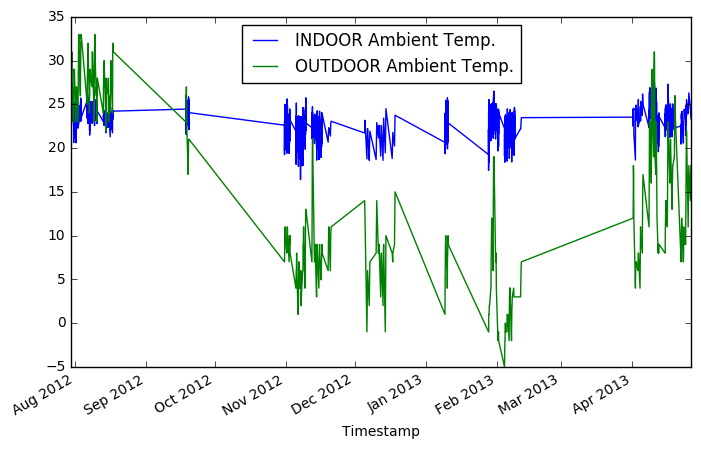

In [15]:
temp_plot = uncont_data.plot('Timestamp',['INDOOR Ambient Temp.','OUTDOOR Ambient Temp.'],figsize = (8,5))
print('The average absolute difference in temperature is: ' + str(np.average(abs(uncont_data['INDOOR Ambient Temp.']-uncont_data['OUTDOOR Ambient Temp.'])))+' Celsius')

The average absolute difference in relative humidity is: 24.7476976987


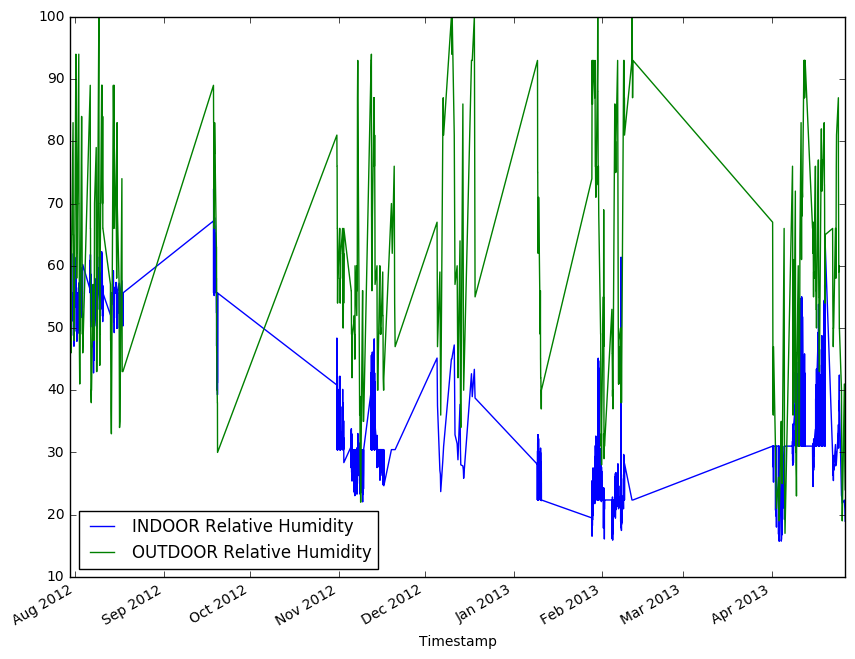

In [24]:
hum_plot = uncont_data.plot('Timestamp',['INDOOR Relative Humidity','OUTDOOR Relative Humidity'],figsize = (10,8))
print('The average absolute difference in relative humidity is: ' + str(np.average(abs(uncont_data['INDOOR Relative Humidity']-uncont_data['OUTDOOR Relative Humidity']))))

The average absolute difference in air velocity is: 4.7549726728


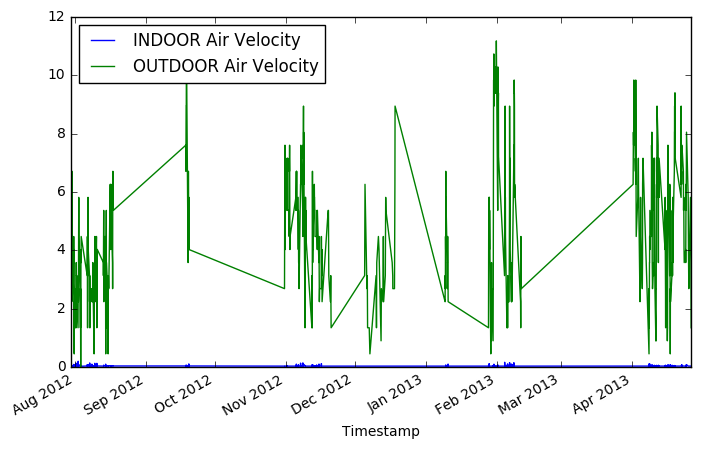

In [25]:
velo_plot = uncont_data.plot('Timestamp',['INDOOR Air Velocity','OUTDOOR Air Velocity'],figsize = (8,5))
print('The average absolute difference in air velocity is: ' + str(np.average(abs(uncont_data['INDOOR Air Velocity']-uncont_data['OUTDOOR Air Velocity']))))

#### Comments:
- There is a large difference between indoor and outdoor conditions in all variables suggesting that the building is well-climate controlled. This implies that our outdoor variable probably will have minimal predictive power in our regression tree.
- Indoor air velocity is probably negligible for this experiment as well because there is almost no variance in its values.

Next we decided to look at how General comfort level related to some of the uncontrollable variables.

Correlation coefficient for Thermal Comfort and Temp:  -0.0484805292266
Correlation coefficient for Thermal Comfort and Relative Humidity:  -0.0327759222587
Correlation coefficient for Thermal Comfort and Air Velocity -0.0558072706453


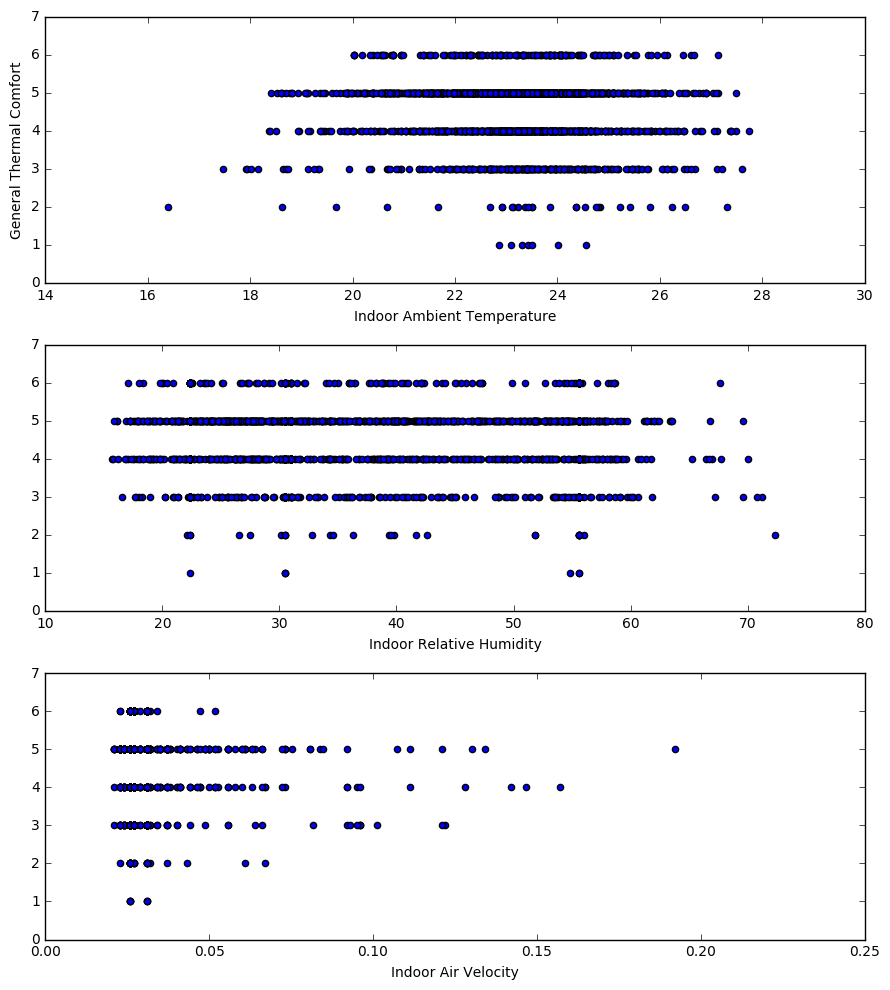

In [67]:
y = uncont_data['General Thermal Comfort (right now)']
x1 = uncont_data['INDOOR Ambient Temp.']
x2 = uncont_data['INDOOR Relative Humidity']
x3 = uncont_data['INDOOR Air Velocity']

fig = plt.figure(figsize=(9,10))
ax1 = plt.subplot(311)
plt.scatter(x1,y)
ax1.set_xlabel("Indoor Ambient Temperature")
ax1.set_ylabel('General Thermal Comfort')
ax1.set_ylim(1,6)

ax2 = plt.subplot(312,sharey = ax1)
plt.scatter(x2,y)
ax2.set_xlabel('Indoor Relative Humidity')

ax3 = plt.subplot(313,sharey = ax1)
plt.scatter(x3,y)
ax3.set_xlabel("Indoor Air Velocity")

plt.tight_layout()
plt.savefig('comfort_subplots.png')

# Correlation Values for each plot
z = uncont_data['General Thermal Comfort (right now)']
print('Correlation coefficient for Thermal Comfort and Temp: ',z.corr(uncont_data['INDOOR Ambient Temp.']))
print('Correlation coefficient for Thermal Comfort and Relative Humidity: ',z.corr(uncont_data['INDOOR Relative Humidity']))
print('Correlation coefficient for Thermal Comfort and Air Velocity',z.corr(uncont_data['INDOOR Air Velocity']))

## Step 3: Regression Trees

Now we're testing how effectively the uncontrollable variables can predict the general comfort level. We'll run two regression trees, one with our environmental and time variables and just splitting on occupant number. If occupant number plays a significant role in predicting the general thermal comfort level than personal preference will tell us more about general thermal comfort level than the uncontrollable variables.

First let's set up our features and response.

In [11]:
X1 = uncont_data[['INDOOR Ambient Temp.','INDOOR Relative Humidity','INDOOR Air Velocity']]
Y = uncont_data['General Thermal Comfort (right now)']

The first regression tree will test our environmental and time variables.

In [27]:
X1_train, X1_test, Y_train, Y_test = train_test_split(X1, Y, test_size=0.3)

reg = tree.DecisionTreeRegressor()
reg = reg.fit(X1_train,Y_train)

r2_score_avg1 = np.average([reg.score(X1_test,Y_test) for i in range(5000)])
print('R^2 value: ', r2_score_avg1)

R^2 value:  -0.64464641659


The second regression tree just checks the predictive power of occupant number alone.

In [16]:
X2 = uncont_data['Occupant Number']
X2 = X2[:,None]


In [28]:
X2_train, X2_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.3)

reg = tree.DecisionTreeRegressor()
reg = reg.fit(X2_train,Y_train)

r2_score_avg2 = np.average([reg.score(X2_test,Y_test) for i in range(5000)])
print('R^2 Value: ',r2_score_avg2)

R^2 Value:  0.290838935016


#### Comments
Our first regression tree had absolutely no predictive power, implying that environmental factors and time of day/year had little to no effect on general thermal comfort. This could be due to the relative stability of indoor temp, air velocity, and humidity year round. The fact that the occupant number alone has some predictive power demonstrates that general thermal comfort is more likely due to personal preference. 

## Step 4: Exporting Images

In [31]:
fig1 = temp_plot.get_figure()
fig1.savefig('temp_plot.png')

fig2 = hum_plot.get_figure()
fig2.savefig('humidity_plot.png')

fig3 = velo_plot.get_figure()
fig3.savefig('velocity_plot.png')

In [29]:
uncont_data.describe()

,Occupant Number,Gender,Age,General Thermal Comfort (right now),INDOOR Ambient Temp.,INDOOR Relative Humidity,OUTDOOR Ambient Temp.,OUTDOOR Relative Humidity,INDOOR Air Velocity,OUTDOOR Air Velocity,Hour,Month
count,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000,2390.000000
mean,11.771967,1.673222,45.625105,4.492887,23.205159,37.424764,14.907066,59.382008,0.029551,4.784450,11.786611,6.030544
std,6.519852,0.469134,12.990387,0.843903,1.466014,13.340594,10.483501,18.619094,0.011062,2.333747,2.932559,3.624989
min,1.000000,1.000000,23.000000,1.000000,16.392222,15.721000,-5.000000,17.000000,0.020828,0.000000,6.000000,1.000000
25%,6.000000,1.000000,32.000000,4.000000,22.441111,25.562250,6.277778,46.000000,0.025908,3.129280,9.000000,2.000000
50%,12.000000,2.000000,51.000000,5.000000,23.327778,31.934500,12.000000,56.000000,0.026924,4.470400,12.000000,7.000000
75%,17.000000,2.000000,56.000000,5.000000,24.062832,52.678000,26.000000,74.000000,0.030988,6.258560,15.000000,9.000000
max,24.000000,2.000000,65.000000,6.000000,27.751111,72.360000,33.000000,100.000000,0.192024,11.176000,21.000000,12.000000
